# [Chefkoch.de](http://www.chefkoch.de/) Maturaarbeit 2017/18
------

## Ziel: 
### Topic modeling:  Dimensionsreduzierung von Rezept Namen in n Kategorien (4.Teil)

## Natural Language Processing:
### Durchgeführte Methoden:
- [Latent Dirichlet Allocation (LDA)](https://de.wikipedia.org/wiki/Latent_Dirichlet_Allocation)
- [Hierarchical Dirichlet process (HDP)](https://en.wikipedia.org/wiki/Hierarchical_Dirichlet_process)
- [Non-negative Matrix Factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization)

## [Hoffman, Blei, Bach: Online Learning for Latent Dirichlet Allocation](https://www.di.ens.fr/~fbach/mdhnips2010.pdf)
## [Wang, Paisley, Blei: Online Variational Inference for the Hierarchical Dirichlet Process](http://proceedings.mlr.press/v15/wang11a/wang11a.pdf)
## [Da Kuang: Nonnegative matrix factorization for interactive topic modeling and document clustering](https://www.cc.gatech.edu/~hpark/papers/nmf_book_chapter.pdf)
## Python Implementation [1](https://radimrehurek.com/gensim/models/ldamodel.html) [2](https://github.com/bmabey/pyLDAvis)

In [4]:
!pip install stop_words
!pip install nltk
!pip3 install -U scikit-learn scipy matplotlib
!pip install seaborn
!pip install gensim
!pip install pyLDAvis

In [14]:
import csv
import random
from operator import itemgetter

from stop_words import get_stop_words
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.manifold import TSNE
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from gensim import corpora, models
import gensim

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline

from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()

In [17]:
def get_recipe_names():
    recipe_names = []
    skip_first = True # col name
    chef_file = 'input/test/chefkoch_rezepte_analysis.csv'
    with open(chef_file, 'r') as f:
        chefkoch = csv.reader(f)
        for row in chefkoch:
            if skip_first:
                skip_first = False
                continue
            try:
                recipe_names.append(row[2])
            except: 
                continue 
    return(recipe_names)

def get_recipe_years():
    recipe_years = []
    skip_first = True # col name
    chef_file = 'input/test/chefkoch_rezepte_analysis.csv'
    with open(chef_file, 'r') as f:
        chefkoch = csv.reader(f)
        for row in chefkoch:
            if skip_first:
                skip_first = False
                continue
            try:
                recipe_years.append(row[-2])
            except: 
                continue 
    return(recipe_years)

recipe_names = get_recipe_names()
print('Anzahl aller Rezeptnamen所有配方名称的数量:', len(recipe_names)) # Anzahl aller Rezeptnamen

print('20 raw recipe names: \n >>>')
pprint(recipe_names[:20])

Anzahl aller Rezeptnamen所有配方名称的数量: 316755
20 raw recipe names: 
 >>>
['Bratapfel-Rotkohl',
 '„Frühstückswolke 7“ aus Fiefhusen',
 'Deichgrafensalat von der Westküste',
 'Geschichteter Kohl',
 'Rinderlendenragout',
 'Blaukraut mit Butter-Maroni',
 'Sauerbraten à la Tick',
 'Punschtorte',
 'Gebackene Oberländer',
 'McMoes bunter Pasta-Topf "Allerlei"',
 'Geschnetzeltes mit gebratenen Radieschen',
 'Ahorn-Bacon-Butter',
 'Warmer Endiviensalat mit Mettwürstchen',
 'Rote-Linsen-Gemüse-Pfanne',
 'Kotelett-Gratin mit Pilzen und Schupfnudeln',
 'Rotkohl',
 'Remouladensauce aus Schmand',
 'Nudeln mit Cashewsauce und Tempeh "Meta-Typ Alpha"',
 'Kohlsuppe',
 'Gemüse-Hackfleischauflauf']


In [18]:
seen = set()
uniq = []
duplicates = []
for x in recipe_names:
    if x not in seen:
        uniq.append(x)
        seen.add(x)
    else: duplicates.append(x)

print('Anzahl einzigartiger Rezeptnamen唯一配方名称的数量:',len(uniq)) # Anzahl einzigartiger Rezeptnamen

duplicates.sort()

print('Anzahl Duplikate重复次数',len(duplicates))
print('20 dupliactes: \n >>>')
pprint(duplicates[:20])

Anzahl einzigartiger Rezeptnamen唯一配方名称的数量: 260907
Anzahl Duplikate重复次数 55848
20 dupliactes: 
 >>>
['24 - Stunden - Salat',
 '3 - Minuten - Brot',
 '3 - Tage - Torte',
 '3 - Tage - Torte',
 '43 Sunset',
 '5 - Minuten - Brot',
 '5 - Minuten - Kuchen',
 '5 - Minuten - Kuchen',
 '5 - Minuten - Tiramisu',
 '6 - Salat',
 '7 - Tassen - Salat',
 '7 - Tassen - Salat',
 '7 - Tassen - Salat',
 '7 Tassen - Salat',
 '7 Tassen Salat',
 'ACE-Marmelade',
 'Aachener Poschweck',
 'Aachener Printen',
 'Aachener Reisfladen',
 'Aalterrine']


# Säubern der Rezept Namen清洁配方名称

## 1. Tokenisierung Tokenize

Nur falls es nicht mit diesem Wort anfängt und der String nachher nicht leer ist仅当它不以该单词开头且之后字符串不为空时

1. replace('und ...', 'mit nichts')
2. replace('à la ...', 'mit nichts')
3. replace('von ...', 'mit nichts')
4. replace('aus ...', 'mit nichts')
5. replace('mit ...', 'mit nichts')
6. replace('ohne ...', 'mit nichts')
7. replace('in ...', 'mit nichts')
8. replace('auf ...', 'mit nichts')
9. replace('für ...', 'mit nichts')
10. replace('nach ...', 'mit nichts')
11. replace('by ...', 'mit nichts')
12. replace('zu ...', 'mit nichts')
13. replace('"..."', 'mit nichts')
14. replace('-', 'space')

In [19]:
import re
# 1
first_iter = []
regex = re.compile(r" und.*", re.IGNORECASE)
for r_name in recipe_names:
    if r_name.lower().startswith('und '):
        first_iter.append(r_name)
        continue # skip
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: first_iter.append(new_name)
    else: first_iter.append(r_name)
print(len(first_iter))
# 2
sec_iter = []
regex = re.compile(r" à la.*", re.IGNORECASE)
for r_name in first_iter:
    if r_name.lower().startswith('à la '):
        sec_iter.append(r_name)
        continue # skip
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: sec_iter.append(new_name)
    else: sec_iter.append(r_name)
print(len(sec_iter))
# 3
third_iter = []
regex = re.compile(r" von.*", re.IGNORECASE)
for r_name in sec_iter:
    if r_name.lower().startswith('von '):
        third_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: third_iter.append(new_name)
    else: third_iter.append(r_name)
print(len(third_iter))
# 4
fourth_iter = []
regex = re.compile(r" aus.*", re.IGNORECASE)
for r_name in third_iter:
    if r_name.lower().startswith('aus '):
        fourth_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: fourth_iter.append(new_name)
    else: fourth_iter.append(r_name)
print(len(fourth_iter))
# 5
fifth_iter = []
regex = re.compile(r" mit.*", re.IGNORECASE)
for r_name in fourth_iter:
    if r_name.lower().startswith('mit '):
        fifth_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: fifth_iter.append(new_name)
    else: fifth_iter.append(r_name)
print(len(fifth_iter))
# 6
sixth_iter = []
regex = re.compile(r" ohne.*", re.IGNORECASE)
for r_name in fifth_iter:
    if r_name.lower().startswith('ohne '):
        sixth_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: sixth_iter.append(new_name)
    else: sixth_iter.append(r_name)
print(len(sixth_iter))
# 7
seventh_iter = []
regex = re.compile(r" in.*", re.IGNORECASE)
for r_name in sixth_iter:
    if r_name.lower().startswith('in '):
        seventh_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: seventh_iter.append(new_name)
    else: seventh_iter.append(r_name)
print(len(seventh_iter))
# 8
eigth_iter = []
regex = re.compile(r" auf.*", re.IGNORECASE)
for r_name in seventh_iter:
    if r_name.lower().startswith('auf '):
        eigth_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: eigth_iter.append(new_name)
    else: eigth_iter.append(r_name)
print(len(eigth_iter))
# 9
ninth_iter = []
regex = re.compile(r" für.*", re.IGNORECASE)
for r_name in eigth_iter:
    if r_name.lower().startswith('für '):
        ninth_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: ninth_iter.append(new_name)
    else: ninth_iter.append(r_name)
print(len(ninth_iter))
# 10
tenth_iter = []
regex = re.compile(r" nach.*", re.IGNORECASE)
for r_name in ninth_iter:
    if r_name.lower().startswith('nach '):
        tenth_iter.append(r_name)# skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: tenth_iter.append(new_name)
    else: tenth_iter.append(r_name)
print(len(tenth_iter))
# 11
eleventh_iter = []
regex = re.compile(r" by.*", re.IGNORECASE)
for r_name in tenth_iter:
    if r_name.lower().startswith('by '): continue # skip
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: eleventh_iter.append(new_name)
    else: eleventh_iter.append(r_name)
print(len(eleventh_iter))
# 12
twelveth_iter = []
regex = re.compile(r" zu.*", re.IGNORECASE)
for r_name in eleventh_iter:
    if r_name.lower().startswith('zu '):
        twelveth_iter.append(r_name)# skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: twelveth_iter.append(new_name)
    else: twelveth_iter.append(r_name)
print(len(twelveth_iter))
# 13
thirteenth_iter = []
regex = re.compile(r'".*?"', re.IGNORECASE)
for r_name in twelveth_iter:
    #if r_name.lower().startswith('zu '): continue # skip
    new_name = regex.sub('', r_name)
    if len(new_name)>1: thirteenth_iter.append(new_name)
    else: thirteenth_iter.append(r_name)
print(len(thirteenth_iter))
# remove leading and ending spaces
fourteenth_iter = []
for r_name in thirteenth_iter:
    new_name = r_name.strip()
    fourteenth_iter.append(new_name)
print(len(fourteenth_iter))
# remove all quotes
fiftheen_iter = []
for r_name in fourteenth_iter:
    new_name = r_name.replace('"', '')
    fiftheen_iter.append(new_name)
print(len(fiftheen_iter))
# 16
sixteenth_iter = []
regex = re.compile(r"'.*?'", re.IGNORECASE)
for r_name in fiftheen_iter:
    #if r_name.lower().startswith('zu '): continue # skip
    new_name = regex.sub('', r_name)
    if len(new_name)>1: sixteenth_iter.append(new_name)
    else: sixteenth_iter.append(r_name)
print(len(sixteenth_iter))
# remove again leading and ending spaces
seventeenth_iter = []
for r_name in sixteenth_iter:
    new_name = r_name.strip()
    seventeenth_iter.append(new_name)
print(len(seventeenth_iter))
# remove all quotes '
eigththeen_iter = []
for r_name in seventeenth_iter:
    new_name = r_name.replace("'", "")
    eigththeen_iter.append(new_name)
print(len(eigththeen_iter))
# 19 remove (...)
nineteenth_iter = []
regex = re.compile(r"\(.*?\)", re.IGNORECASE)
for r_name in eigththeen_iter:
    #if r_name.lower().startswith('zu '): continue # skip
    new_name = regex.sub('', r_name)
    if len(new_name)>2: nineteenth_iter.append(new_name)
    else: nineteenth_iter.append(r_name)
print(len(nineteenth_iter))
# remove -
twenteenth_iter = []
for r_name in nineteenth_iter:
    if r_name.startswith('- '):
        new_name = r_name.replace("- ", "")
        twenteenth_iter.append(new_name)
    elif r_name.startswith('-'):
        new_name = r_name.replace("-", "")
        twenteenth_iter.append(new_name)
    else: twenteenth_iter.append(r_name)
print(len(twenteenth_iter))
# remove again leading and ending spaces
twentyoneth_iter = []
for r_name in twenteenth_iter:
    new_name = r_name.strip()
    twentyoneth_iter.append(new_name)
print(len(twentyoneth_iter))
# add space around -
twentytwoth_iter = []
for r_name in twentyoneth_iter:
    new_name = r_name.replace("-", " - ")
    twentytwoth_iter.append(new_name)
print(len(twentytwoth_iter))
# 23 remove all numbers
twentytird_iter = []
regex = re.compile(r'[0-9].*?(?=\s)', re.IGNORECASE)
for r_name in twentytwoth_iter:
    #if r_name.lower().startswith('zu '): continue # skip
    new_name = regex.sub('', r_name)
    twentytird_iter.append(new_name)
print(len(twentytird_iter))
# 24 remove everything but letters
twentyfourth_iter = []
regex = re.compile(r'[^A-Za-zäöüßéàèêëïùâîûç]+', re.IGNORECASE)
for r_name in twentytird_iter:
    new_name = regex.sub(' ', r_name)
    twentyfourth_iter.append(new_name)
print(len(twentyfourth_iter))
# remove again leading and ending spaces
twentyfifth_iter = []
for r_name in twentyfourth_iter:
    new_name = r_name.strip()
    twentyfifth_iter.append(new_name)
print(len(twentyfifth_iter))
# 26 remove all single letters
twentysixth_iter = []
regex = re.compile(r'(?:^| )\w(?:$| )', re.IGNORECASE)
for r_name in twentyfifth_iter:
    new_name = regex.sub(' ', r_name).strip()
    twentysixth_iter.append(new_name)
print(len(twentysixth_iter))
# 27 remove empty entries
twentyseventh_iter = []
for r_name in twentysixth_iter:
    if len(r_name) < 1: twentyseventh_iter.append('error') # just skip
    else: twentyseventh_iter.append(r_name)
print(len(twentyseventh_iter))
# 28
twentyeigth_iter = []
regex = re.compile(r" im.*", re.IGNORECASE)
for r_name in twentyseventh_iter:
    if r_name.lower().startswith('im '):
        twentyeigth_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: twentyeigth_iter.append(new_name)
    else: twentyeigth_iter.append(r_name)
print(len(sixth_iter))

<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:21: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:32: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:43: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:54: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:65: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:76: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:87: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:98: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:109: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:118: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:129: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:248: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:21: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:32:

316755
316755


/var/folders/l6/8hfvh79x19x6b73t634zs2c00000gq/T/ipykernel_47394/3592512037.py:32: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: third_iter.append(new_name)
/var/folders/l6/8hfvh79x19x6b73t634zs2c00000gq/T/ipykernel_47394/3592512037.py:43: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: fourth_iter.append(new_name)


316755
316755


/var/folders/l6/8hfvh79x19x6b73t634zs2c00000gq/T/ipykernel_47394/3592512037.py:54: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: fifth_iter.append(new_name)


316755
316755


/var/folders/l6/8hfvh79x19x6b73t634zs2c00000gq/T/ipykernel_47394/3592512037.py:65: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: sixth_iter.append(new_name)
/var/folders/l6/8hfvh79x19x6b73t634zs2c00000gq/T/ipykernel_47394/3592512037.py:76: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: seventh_iter.append(new_name)


316755
316755


/var/folders/l6/8hfvh79x19x6b73t634zs2c00000gq/T/ipykernel_47394/3592512037.py:87: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: eigth_iter.append(new_name)
/var/folders/l6/8hfvh79x19x6b73t634zs2c00000gq/T/ipykernel_47394/3592512037.py:98: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: ninth_iter.append(new_name)


316755
316755


/var/folders/l6/8hfvh79x19x6b73t634zs2c00000gq/T/ipykernel_47394/3592512037.py:109: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: tenth_iter.append(new_name)
/var/folders/l6/8hfvh79x19x6b73t634zs2c00000gq/T/ipykernel_47394/3592512037.py:118: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: eleventh_iter.append(new_name)


316755
316755


/var/folders/l6/8hfvh79x19x6b73t634zs2c00000gq/T/ipykernel_47394/3592512037.py:129: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: twelveth_iter.append(new_name)


316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755


/var/folders/l6/8hfvh79x19x6b73t634zs2c00000gq/T/ipykernel_47394/3592512037.py:248: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(new_name) is not 0: twentyeigth_iter.append(new_name)


## Nach 28 handgefertigten Bedingungen sieht das ganze so aus经过28个手工条件，整个东西变成了这个样子:

In [20]:
print('Nach 28 handgefertigten Bedingungen sieht das ganze so aus: \n >>>')
pprint(random.sample(twentyeigth_iter, len(twentyeigth_iter))[:50])

Nach 28 handgefertigten Bedingungen sieht das ganze so aus: 
 >>>
['Champignon Brokkoli',
 'Spinat',
 'Nudeln',
 'Eisbergsalat',
 'Einfacher Rhabarberkuchen',
 'Brokkoli Salat',
 'Weißkohltopf',
 'Ochsenmaulsalat',
 'Lamm',
 'Bresaola pikant',
 'Spargel',
 'Mariniertes Putenbrustfilet',
 'Butterkeks Kuchen',
 'Pilav',
 'Vanillekipferl',
 'Vitello allUcceletto con Salsa al Limone',
 'Pilzchutney',
 'Fischsuppe',
 'Russischer Hackfleischtopf',
 'Schoko Bienenstich',
 'Schokopudding',
 'Mandel Gugelhupf la Mäusle',
 'Blitz Quarkkuchen',
 'Haferflocken Erdnuss Kekse',
 'Mandel Schoko Torte',
 'Butterplätzchen',
 'Grapefruit Creme',
 'Panierter Feta',
 'BJs Trail Beans',
 'Gefüllte Cannelloni',
 'Schweinspfeffer',
 'Marzipan Mohn Franzbrötchen',
 'Luftschlangen',
 'Curry Reissalat',
 'Safran Spaghetti',
 'Fischauflauf',
 'Remoulade',
 'Klutzu',
 'Beschwipste Apfelmuffins',
 'Erdbeeren',
 'Polpette di Melanzane',
 'Kürbiscremesuppe',
 'Kokos Zwetschgenkuchen',
 'Knusper Karamell Kekse',
 'Br

## 2. Stoppwörter entfernen und Stammformreduktion

Unwichtige Wörter wie *welche*, *sich*, *manches*, *einige* etc. entfernen und Wörter auf ihren Wortstamm reduzieren.
删除停用词和词干形式缩减¶
删除不重要的单词，例如 which、self、some、some 等，并将单词缩减到词根。

In [21]:
de_stop = get_stop_words('german')
s_stemmer = SnowballStemmer('german')
tokenizer = RegexpTokenizer(r'\w+')
final_names = []
filter_words_ = ['low carb',
               'vegane', 
               'smokeys',
               'schnelle',
               'schneller',
               'single',
               'veganer',
               'überbackene',
               'bunter',
               'gebratene',
               'grüner',
               'grünes', 
               'vegetarische',
               'italienisch',
               'scharfe',
               'krümeltigers',
               'pfanne',
               'mini',
               'warmer',
               'gefüllt',
               'gefüllte',
               'pikante',
               'schnelles',
               'rezept',
               'dessert',
               'bunte',
               'gebackene',
               'feierabend',
               'omas',
               'topf',
               'mediterrane',
               'mal',
               'saftig',
               'mediterraner',
               'saftiger',
               'saftiges',
                 'nr',
                 'abendessen',
                 'achims']

for recipe_name in twentyeigth_iter:
    raw = recipe_name.lower()
    tokens = tokenizer.tokenize(raw)
    stop_t = [recipe_name for recipe_name in tokens if not recipe_name in de_stop and not recipe_name in filter_words_]
    stem_t = [i for i in stop_t if len(i)>1]
    if len(stem_t)==0: final_names.append(['error'])
    else: final_names.append(stem_t)

print('Fertig gesäuberte Rezeptnamen: \n >>>')
pprint(final_names[:20])

Fertig gesäuberte Rezeptnamen: 
 >>>
[['bratapfel', 'rotkohl'],
 ['frühstückswolke'],
 ['deichgrafensalat'],
 ['geschichteter', 'kohl'],
 ['rinderlendenragout'],
 ['blaukraut'],
 ['sauerbraten'],
 ['punschtorte'],
 ['oberländer'],
 ['mcmoes', 'pasta'],
 ['geschnetzeltes'],
 ['ahorn', 'bacon', 'butter'],
 ['endiviensalat'],
 ['rote', 'linsen', 'gemüse'],
 ['kotelett', 'gratin'],
 ['rotkohl'],
 ['remouladensauce'],
 ['nudeln'],
 ['kohlsuppe'],
 ['gemüse', 'hackfleischauflauf']]


In [22]:
print(len(final_names))
print(len(twentyeigth_iter))

316755
316755


In [23]:
sorted(final_names)[:20]

[['aachener', 'feuerzangenbowle'],
 ['aachener', 'poschweck'],
 ['aachener', 'poschweck'],
 ['aachener', 'printen'],
 ['aachener', 'printen'],
 ['aachener', 'printen'],
 ['aachener', 'printen', 'ii'],
 ['aachener', 'printen', 'iii'],
 ['aachener', 'printen', 'schichtspeise'],
 ['aachener', 'printenauflauf'],
 ['aachener', 'reisfladen'],
 ['aachener', 'reisfladen'],
 ['aachener', 'suppe'],
 ['aal'],
 ['aal'],
 ['aal'],
 ['aal'],
 ['aal'],
 ['aal'],
 ['aal']]

# Topic Modeling

## Versuch 1: Latent Dirichlet Allocation (LDA) mit 50 Topics

In [24]:
dictionary = corpora.Dictionary(final_names)
# save dictionary
#dictionary.save('input/test/topic_modeling_dictionary_2.dict')
corpus = [dictionary.doc2bow(text) for text in final_names]
# save corpus
#corpora.MmCorpus.serialize('input/test/corpus_2_lda.mm', corpus)

In [25]:
print(dictionary)

Dictionary<60477 unique tokens: ['bratapfel', 'rotkohl', 'frühstückswolke', 'deichgrafensalat', 'geschichteter']...>


In [69]:
%%time
# generate LDA model
ldamodel = models.LdaMulticore(corpus=corpus, num_topics=50, id2word = dictionary)
ldamodel.save('input/test/kategorien_50_60477_lda.model')

CPU times: user 2.87 s, sys: 4.24 s, total: 7.11 s
Wall time: 13.7 s


In [44]:
# ldamodel = models.ldamodel.LdaModel.load('input/test/kategorien_50_60477_lda.model')

In [70]:
ldamodel.print_topics()

[(24,
  '0.151*"käse" + 0.095*"pfannkuchen" + 0.077*"kartoffelsuppe" + 0.075*"mousse" + 0.050*"likör" + 0.048*"au" + 0.034*"speck" + 0.033*"chocolat" + 0.027*"ziegenkäse" + 0.021*"erdbeer"'),
 (14,
  '0.218*"muffins" + 0.149*"schoko" + 0.083*"bananen" + 0.075*"pasta" + 0.039*"walnuss" + 0.032*"sauerkraut" + 0.031*"lebkuchen" + 0.025*"einfache" + 0.019*"kirsch" + 0.018*"traum"'),
 (5,
  '0.152*"pizza" + 0.064*"cake" + 0.054*"senf" + 0.040*"fladenbrot" + 0.039*"amerikanischer" + 0.028*"cheese" + 0.021*"nudeln" + 0.021*"rosinen" + 0.020*"honig" + 0.020*"bleu"'),
 (13,
  '0.126*"kohlrabi" + 0.095*"champignon" + 0.037*"scharf" + 0.033*"cranberry" + 0.032*"spinat" + 0.019*"bällchen" + 0.018*"kartoffelbrei" + 0.015*"süß" + 0.013*"eiweiß" + 0.011*"lauch"'),
 (15,
  '0.052*"asia" + 0.041*"sauce" + 0.035*"brownie" + 0.034*"thailändische" + 0.024*"hähnchensalat" + 0.022*"süßsauer" + 0.015*"dunkle" + 0.014*"cookie" + 0.006*"chocolate" + 0.005*"style"'),
 (27,
  '0.153*"marzipan" + 0.114*"aprikosen

## Visualisieren des LDA Model mit [pyLDAvis](https://github.com/bmabey/pyLDAvis)

In [71]:
vis_data = gensimvis.prepare(ldamodel, corpus, dictionary)

/Users/z0h03ws/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/z0h03ws/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


## Interaktive Graphik交互式图形

In [72]:
pyLDAvis.display(vis_data)

In [48]:
# from IPython.display import Image
# PATH = "/Users/Muriz/Desktop/"
# Image(filename = PATH + "topic.png", width='60%', height=140)

Mit einem kurzen Skript können zusammenhängende Rezepte zu einem Begriff ausgegeben werden.

In [73]:
def get_related_recipes(term, top):
    print(">>>>>",top," top recipes related to ",term,"<<<<<<")
    related_docid = []
    doc_topics = ldamodel.get_document_topics(corpus, minimum_probability=0.10)
    term_topics =  ldamodel.get_term_topics(term, minimum_probability=0.000001)
    for k,topics in enumerate(doc_topics):
        if topics:
            topics.sort(key = itemgetter(1), reverse=True)
            if topics[0][0] == term_topics[0][0]:
                related_docid.append((k,topics[0][1]))
    
    related_docid.sort(key = itemgetter(1), reverse=True)
    for j,doc_id in enumerate(related_docid):
        print(final_names[doc_id[0]],"\n",doc_id[1],"\n")
        if j == (top-1):
            break


苹果

In [74]:
get_related_recipes('apfel', 10)

>>>>> 10  top recipes related to  apfel <<<<<<
['tart', 'susu', 'kacang', 'mete', 'dan', 'buah', 'kelapa'] 
 0.877466 

['tropea', 'zwiebeln', 'würstchen', 'grana', 'padano', 'quiche'] 
 0.85998076 

['quark', 'dinkel', 'grieß', 'vollkorn', 'eierkuchen'] 
 0.8366643 

['blumenkohl', 'oliven', 'knoblauch', 'schnitzel', 'auflauf'] 
 0.836664 

['himbeer', 'mascarpone', 'torte', 'pi', 'atakuchen'] 
 0.8366553 

['süßer', 'römer', 'trifft', 'saure', 'endivie'] 
 0.83664775 

['joghurt', 'himbeer', 'torte'] 
 0.7549992 

['himbeer', 'joghurt', 'torte'] 
 0.7549992 

['himbeer', 'joghurt', 'torte'] 
 0.75499916 

['himbeer', 'joghurt', 'torte'] 
 0.75499916 



We can see that himbeer覆盆子 and apfel 苹果 are belonging to one topic.

# Versuch 2
## Hierarchical Dirichlet Process

### Der Unterschied zu LDA besteht hier, das mit HDP keine Anzahl von Topics von vornherein bestimmt werden muss. Die Anzahl empfohlener Topics wird beim Lauf selbst bestimmt. Mit Parameter T kann man bestimmen, wie viele Topics mindestens berechnet werden müssen.
分层狄利克雷过程
与 LDA 的不同之处在于，使用 HDP，无需从一开始就确定主题的数量。推荐主题的数量是在运行过程中确定的。 T 参数可用于确定至少必须计算多少个主题。

In [79]:
%%time
# generate HDP model
hdp = models.hdpmodel.HdpModel(corpus, dictionary, T=20) # I tried 20, 50, 100 and the results are almost the same
hdp.save('input/test/kategorien_hdp_new.model')

CPU times: user 2min 59s, sys: 753 ms, total: 3min
Wall time: 3min


In [19]:
hdp = models.hdpmodel.HdpModel.load('input/test/kategorien_hdp_new.model')

In [80]:
hdp.print_topics()[:10]

[(0,
  '0.003*salat + 0.002*torte + 0.002*kuchen + 0.002*apfel + 0.002*muffins + 0.001*kartoffel + 0.001*schoko + 0.001*spaghetti + 0.001*tomaten + 0.001*gemüse'),
 (1,
  '0.003*salat + 0.002*torte + 0.002*kuchen + 0.002*apfel + 0.002*muffins + 0.001*kartoffel + 0.001*schoko + 0.001*spaghetti + 0.001*tomaten + 0.001*gemüse'),
 (2,
  '0.003*salat + 0.002*torte + 0.002*kuchen + 0.002*apfel + 0.002*muffins + 0.001*kartoffel + 0.001*spaghetti + 0.001*schoko + 0.001*tomaten + 0.001*gemüse'),
 (3,
  '0.003*salat + 0.002*torte + 0.002*kuchen + 0.002*apfel + 0.002*muffins + 0.001*kartoffel + 0.001*schoko + 0.001*spaghetti + 0.001*tomaten + 0.001*gemüse'),
 (4,
  '0.003*salat + 0.002*torte + 0.002*kuchen + 0.002*apfel + 0.002*muffins + 0.001*kartoffel + 0.001*schoko + 0.001*spaghetti + 0.001*tomaten + 0.001*gemüse'),
 (5,
  '0.003*salat + 0.002*torte + 0.002*kuchen + 0.002*apfel + 0.002*muffins + 0.001*kartoffel + 0.001*spaghetti + 0.001*schoko + 0.001*tomaten + 0.001*gemüse'),
 (6,
  '0.003*sa

## Auch hier kann man das Ergebnis visualisieren
您还可以在此处可视化结果

In [81]:
vis_data_hdp = gensimvis.prepare(hdp, corpus, dictionary)

/Users/z0h03ws/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/z0h03ws/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/z0h03ws/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/z0h03ws/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/z0h03ws/opt/anaconda3/lib/

In [82]:
pyLDAvis.display(vis_data_hdp)

### Der Versuch mit HDP liefert leider schlechte Ergebnisse. Viele Kategorien überlappen sich stark, z.B. Salat, Torte, Kuchen und Apfel sind die Top-Ergebnisse in fast jedem Topic. Das Ergbniss von HDP wird nicht in Betrachtung gezogen.
不幸的是，对 HDP 的尝试带来了糟糕的结果。许多类别重叠严重，例如沙拉、馅饼、蛋糕和苹果几乎在每个主题中都是最佳结果。不考虑HDP的结果

# Versuch 3
## Non-negative Matrix Factorization

In [83]:
# rezepte_csv_analysis = pd.read_csv('input/test/chefkoch_rezepte_analysis.csv')
# rezepte_csv_analysis.head(2) # zeige erste zwei zeilen

,Unnamed: 0,recipe_id,recipe_name,average_rating,stars_shown,votes,difficulty,preparation_time,date,has_picture
0,0,3449791514066439,Bratapfel-Rotkohl,2.5,unb,0.0,normal,45.0,2017-12-24,no
1,1,3449721514056932,„Frühstückswolke 7“ aus Fiefhusen,2.5,unb,0.0,pfiffig,15.0,2017-12-24,no


### Zuerst wird eine zusätzliche Spalte hinzugefügt zur  chefkoch_rezepte_analysis.csv Datei mit dem 'sauberen' Namen.

In [85]:
# rezepte_csv_analysis.drop(rezepte_csv_analysis.columns[[0, 3, 4, 5, 6, 7, 9]], axis=1, inplace=True)
# rezepte_csv_analysis['date'] = pd.to_datetime(rezepte_csv_analysis['date'])
# rezepte_csv_analysis['year']=rezepte_csv_analysis.date.dt.year
# rezepte_csv_analysis['clean_name'] = data_samples
# rezepte_csv_analysis.head(2)
# rezepte_csv_analysis.to_csv('input/test/chefkoch_rezepte_analysis_cleannames.csv')

In [86]:
rezepte_csv_analysis=pd.read_csv('input/test/chefkoch_rezepte_analysis_cleannames.csv')

### 3.1 Non-negative Matrix Factorization:

In [110]:
n_topics = 300
n_top_words = 20

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_[:10]): # just show first 10 topics
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [111]:
data_samples = [' '.join(ti) for ti in final_names]
print(len(data_samples))

316755


In [112]:
sorted(data_samples)[:20]

['aachener feuerzangenbowle',
 'aachener poschweck',
 'aachener poschweck',
 'aachener printen',
 'aachener printen',
 'aachener printen',
 'aachener printen ii',
 'aachener printen iii',
 'aachener printen schichtspeise',
 'aachener printenauflauf',
 'aachener reisfladen',
 'aachener reisfladen',
 'aachener suppe',
 'aal',
 'aal',
 'aal',
 'aal',
 'aal',
 'aal',
 'aal']

## Insgesamt wurden 2 Modelle berechnet:
1. Mit 250 Kategorien auf meiner lokalen Hardware
2. Mit 300 Kategorien auf einer [Amazon EC2-Instanz](https://aws.amazon.com/de/ec2/instance-types/) berechnet, da mein lokaler PC nicht mit genügend schneller Hardware ausgestattet ist.

In [113]:
%%time
# tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.99, max_features=None)
tfidf = tfidf_vectorizer.fit_transform(data_samples)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

Extracting tf-idf features for NMF...
CPU times: user 914 ms, sys: 15 ms, total: 929 ms
Wall time: 928 ms


/Users/z0h03ws/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Erste Einblicke: Ranking der grössten TF-IDF Werte im Dokument

In [114]:
import operator
def rank_terms(A, terms):
    sums = A.sum(axis=0)
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

In [115]:
ranking = rank_terms(tfidf, tfidf_feature_names)
for i, pair in enumerate(ranking[0:50]):
    print( "%02d. %s (%.2f)" % (i+1, pair[0], pair[1]))

01. salat (2935.18)
02. spaghetti (2429.36)
03. torte (2196.21)
04. kuchen (1970.08)
05. nudeln (1856.08)
06. muffins (1823.38)
07. apfel (1679.88)
08. kartoffel (1651.78)
09. tomaten (1628.55)
10. schoko (1520.09)
11. gemüse (1464.49)
12. nudelsalat (1421.97)
13. hähnchen (1358.69)
14. suppe (1306.70)
15. paprika (1301.66)
16. curry (1271.75)
17. pasta (1189.32)
18. zucchini (1179.31)
19. erdbeer (1164.30)
20. bananen (1150.77)
21. käse (1146.86)
22. apfelkuchen (1133.69)
23. lachs (1055.75)
24. spargel (1030.62)
25. schweinefilet (1022.06)
26. käsekuchen (1010.36)
27. kartoffelsalat (965.17)
28. kokos (954.14)
29. error (944.00)
30. quark (932.04)
31. reis (908.07)
32. auflauf (882.07)
33. kürbis (870.52)
34. joghurt (858.62)
35. sauce (849.17)
36. rote (837.60)
37. kirsch (826.79)
38. nudelauflauf (821.69)
39. creme (806.50)
40. pizza (803.71)
41. orangen (795.90)
42. lasagne (788.46)
43. himbeer (780.59)
44. dip (779.24)
45. spinat (750.39)
46. möhren (742.89)
47. sahne (729.83)
48

In [116]:
# Fit the NMF model
nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5, verbose=2, max_iter=5).fit(tfidf)
print()

/Users/z0h03ws/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


violation: 1.0
violation: 0.01856526941116769
violation: 0.00781764444053731
violation: 0.005119904174234044
violation: 0.0028764086484772463


/Users/z0h03ws/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 5 reached. Increase it to improve convergence.
  warnings.warn(


In [117]:
import os
os.makedirs('input/test/topic_modeling/',exist_ok=True)
joblib.dump(nmf, 'input/test/topic_modeling/nmf_allfeat_100000samp_300topic.pkl')
nmf_300 = joblib.load('input/test/topic_modeling/nmf_allfeat_100000samp_300topic.pkl')

In [98]:
# saving NMF model
#joblib.dump(nmf, 'input/test/topic_modeling/nmf_allfeat_100000samp_250topic.pkl')

['input/test/topic_modeling/nmf_allfeat_100000samp_250topic.pkl']

In [99]:
# loading NMF 250 cat model
#nmf_250 = joblib.load('input/test/topic_modeling/nmf_allfeat_100000samp_250topic.pkl')

In [101]:
# loading NMF 300 cat model
#nmf_300 = joblib.load('input/test/topic_modeling/nmf_allfeat_100000samp_250topic_cloud.pkl')

## Mittelmässige Ergebnisse liefert das 1. NMF model:

In [102]:
#print_top_words(nmf_250, tfidf_feature_names, 5)

Topic #0:
spaghetti carbonara olio aglio al
Topic #1:
salat gemischter melonen chicoree bulgur
Topic #2:
nudeln chinesische asia mie wok
Topic #3:
muffins blaubeer cranberry herzhafte saftige
Topic #4:
nudelsalat leichter sommerlicher scharfer chinesischer
Topic #5:
tomaten oliven salsa basilikum aufstrich
Topic #6:
torte philadelphia linzer raffaello baiser
Topic #7:
kuchen streusel mohn nuss baiser
Topic #8:
pasta one pot asciutta al
Topic #9:
hähnchen spieße scharfes cordon bleu



## Ausgezeichnete Ergebnisse liefert das 2. NMF model:

In [118]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf_300, tfidf_feature_names, 10) # just show first 10 topics

Topic #0:
spaghetti carbonara olio aglio al sabo di puttanesca mare nester
Topic #1:
salat gemischter melonen chicoree bulgur radieschen sellerie quinoa lauwarmer matjes
Topic #2:
nudeln chinesische asia mie wok udon schwarze leichte china parmesan
Topic #3:
muffins blaubeer cranberry herzhafte saftige streusel chocolate haferflocken erdnussbutter mohn
Topic #4:
nudelsalat leichter sommerlicher scharfer chinesischer asiatischer mediterran sommer roter vegetarischer
Topic #5:
tomaten oliven salsa basilikum aufstrich getrocknete ciabatta gratinierte geschmorte sahnesoße
Topic #6:
torte philadelphia linzer raffaello baiser maracuja mokka buttercreme giotto stracciatella
Topic #7:
kuchen streusel mohn nuss baiser zwetschgen buttermilch grieß schmand marmor
Topic #8:
pasta one pot asciutta al alla sommerliche fagioli cremige gorgonzola
Topic #9:
hähnchen spieße scharfes cordon bleu mariniertes tandoori saté geschmortes überbackenes



/Users/z0h03ws/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Tfidf-Matrix zu NMF-Embedding

In [119]:
nmf_embedding = nmf_300.transform(tfidf)
#nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)

/Users/z0h03ws/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


violation: 1.0
violation: 0.005005575518157399
violation: 0.0005290616489095623
violation: 0.00014832596230913064
violation: 6.968016914588203e-05
Converged at iteration 6


/Users/z0h03ws/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 5 reached. Increase it to improve convergence.
  warnings.warn(


# Resultat

## Die Matrize *nmf_embedding* enthält nun das gesuchte, vermutete Verhältnis zwischen Rezeptname und Kategorie. Für jedes Rezept der 316'755 Rezepte findet man die Gewichte, je höher desto stärker mit der Kateogrie assoziiert.

nmf_embedding 矩阵现在包含搜索到的、假定的配方名称和类别之间的关系。对于 316,755 种食谱中的每一种，您都可以找到权重，权重越高，与类别的关联度越高

In [120]:
nmf_embedding.shape

(316755, 300)

### Zum Beispiel:
#### Der 11. Rezeptname ist Geschnetzeltes mit gebratenen Radieschen. Welcher Kategorie der 300 gehört dieses Rezept an?

In [121]:
recipe_names[10:11]

['Geschnetzeltes mit gebratenen Radieschen']

### Ergebnis: Das Modell ist sich mit 0.13 sicher, dass es zur 74. Kategorie angehört.

In [122]:
nmf_embedding[10,:].round(2)

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.

Tatsächlich ist der Name der 74 Kategorie *geschnetzeltes* und damit liegt das Model richtig.

In [127]:
# topics_category_300[73]

# Das Spiel umdrehen

## Wie sieht es aber aus, wenn man eine Kategorie zu einem bestimmten String sucht?
扭转局势
但是，如果您正在寻找特定字符串的类别，它会是什么样子呢？

In [124]:
nmf_300.components_.shape

(300, 60477)

## Als Test gibt man 'carbonara' an.

In [125]:
term_index = tfidf_feature_names.index('carbonara')
nmf_300.components_[:,term_index].round(2)

array([0.13, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

## Am sichersten ist es, dass es zur ersten Kategorie gehören muss.
## Überprüfung: 1. Kategorie ist:它必须属于第一类，这是最安全的。
验证：第一类是：

In [128]:
# topics_category_300[0]

spaghetti und carbonara passt!

## Top 300 Vorschläge vom 2. NFM Model für Kategorien:

##### Kleiner Ausschnit (10 Kategorien)
## 来自第二个 NFM 模型的前 300 个类别建议：

##### 小摘录（10类）

In [129]:
top_idx = np.argsort(nmf_embedding,axis=0)[-1:]
show_ten = 10
count_idxs = 0
for idxs in top_idx.T:
    if count_idxs == show_ten: break
    print("\nTopic {}:".format(count_idxs))
    for idx in idxs:
        print(final_names[idx])
    count_idxs += 1


Topic 0:
['spaghetti']

Topic 1:
['salat']

Topic 2:
['nudeln']

Topic 3:
['muffins']

Topic 4:
['nudelsalat']

Topic 5:
['tomaten']

Topic 6:
['torte']

Topic 7:
['kuchen']

Topic 8:
['pasta']

Topic 9:
['hähnchen']


In [133]:
len(top_idx.T)

300

In [136]:
count_idxs = 0
for idxs in top_idx.T:
    words = []
    for idx in idxs:
        words.extend(final_names[idx])
    with open('input/test/categories_300.txt', 'a') as the_file:
        the_file.write(str(' '.join(words)+'\n'))
    count_idxs += 1

### Die Kategorien für die 300 empfohlenen Topics müssen manuell ausgewertet werden. Die fertige Liste mit 300 Kategorien findet sich unter *input/test/categories_300.txt*
### 300 个推荐主题的类别必须手动评估。包含 300 个类别的完成列表可以在 *input/test/categories_300.txt* 下找到

In [137]:
topics_category_300 = []
cat_file = open('input/test/categories_300.txt', 'r')
cat_file_lines = cat_file.readlines()
for line in cat_file_lines:
    topics_category_300.append(line.strip())

In [138]:
topics_category_300[:10]

['spaghetti',
 'salat',
 'nudeln',
 'muffins',
 'nudelsalat',
 'tomaten',
 'torte',
 'kuchen',
 'pasta',
 'hähnchen']

### Die am übereinstimmensten Rezepte für Kategorie:
### 类别最匹配的食谱：

In [139]:
def get_top_recipes_for_category(recipes_all_list, w_vector, recipe_index, top):
    top_indic = np.argsort(w_vector[:,recipe_index])[::-1] # umdrehen
    top_result = [] # return result as list
    for rec_index in top_indic[0:top]:
        top_result.append(recipes_all_list[rec_index])
    return top_result

### Beispiel: die besten Rezepte für Kategorie Spaghetti (1. Kategorie)示例：类别意大利面（第 1 类别）的最佳食谱

In [140]:
recipes_for_category = get_top_recipes_for_category(recipe_names, nmf_embedding, 0, 10)

In [141]:
for i, rezept_val in enumerate(recipes_for_category):
    print("%02d. %s" % ((i+1), rezept_val))

01. Spaghetti nach italienischer Art
02. Spaghetti mit Wirsingpesto
03. Spaghetti mit Basilikumpesto
04. Spaghetti mit zwei Soßen
05. Spaghetti mit Paprika - Tomaten - Püree und Rinderfiletstreifen
06. Spaghetti mit Wirsing und Schafskäse
07. Spaghetti in Thymianrahm mit Cocktailtomaten
08. Spaghetti mit Pfirsich - Ingwer Sauce
09. Spaghetti  mit Chili und Knoblauch nach Chris
10. Spaghetti mit Ziegenkäse und Zucchini


### Beispiel: die besten Rezepte für Kategorie Paprika (15. Kategorie)示例：类别辣椒的最佳食谱（第 15 类）

In [142]:
recipes_for_category = get_top_recipes_for_category(recipe_names, nmf_embedding, 14, 10)

In [143]:
for i, rezept_val in enumerate(recipes_for_category):
    print("%02d. %s" % ((i+1), rezept_val))

01. Gefüllte Paprika
02. Gefüllte Paprika auf frischer Tomatensauce
03. Gefüllte Paprika
04. Gefüllte Paprika mit Tomatenmatsch
05. Gefüllte Paprika
06. Gefüllte Paprika mit Chili con Carne
07. Paprika mit Thunfisch
08. Gefüllte Paprika mit Hackfleisch
09. Paprika - Ingwer - Sauce
10. Gefüllte Paprika in Alufolie


### Die am übereinstimmenste Kategorie für ein Rezept:食谱最匹配的类别：

In [144]:
def get_top_cat_for_recipe(recipes_all_list, w_vector):
    final_recipes_cat_name = []
    recipe_cat_link = []
    for r in range(len(recipes_all_list)):
        one_hot_matrix = w_vector[r,:]
        all_zeros = not one_hot_matrix.any() # no fitting category
        if all_zeros: recipe_cat_link.append(-1) # no fitting category
        else:
            top_indic = np.argsort(one_hot_matrix)[::-1][0] # 1. umdrehen 2. return erste
            recipe_cat_link.append(top_indic)
    for num in recipe_cat_link:
        if num == -1: final_recipes_cat_name.append('no_cat')
        else: final_recipes_cat_name.append(topics_category_300[num])
    return final_recipes_cat_name

In [145]:
categories_for_recipes = get_top_cat_for_recipe(recipe_names, nmf_embedding)

In [146]:
count_no_cat = 0
for recipe_s in categories_for_recipes:
    if recipe_s == 'no_cat': count_no_cat+=1
print('Für {} Rezepte wurde keine Kategorie festgestellt'.format(count_no_cat))

Für 129240 Rezepte wurde keine Kategorie festgestellt


## Die passende Kategorie als Spalte hinzufügen:添加适当的类别作为列：

In [147]:
rezepte_csv_analysis.head()

,Unnamed: 0,recipe_id,recipe_name,date,year,clean_name
0,0,3449791514066439,Bratapfel-Rotkohl,2017-12-24,2017,bratapfel rotkohl
1,1,3449721514056932,„Frühstückswolke 7“ aus Fiefhusen,2017-12-24,2017,frühstückswolke
2,2,3449701514054063,Deichgrafensalat von der Westküste,2017-12-24,2017,deichgrafensalat
3,3,3449651514047893,Geschichteter Kohl,2017-12-24,2017,geschichteter kohl
4,4,3449681514052511,Rinderlendenragout,2017-12-24,2017,rinderlendenragout


In [148]:
rezepte_csv_analysis['category'] = categories_for_recipes

In [149]:
rezepte_csv_analysis.to_csv('input/test/chefkoch_rezepte_analysis_with_category.csv')

In [150]:
rezepte_csv_analysis.head(10)

,Unnamed: 0,recipe_id,recipe_name,date,year,clean_name,category
0,0,3449791514066439,Bratapfel-Rotkohl,2017-12-24,2017,bratapfel rotkohl,bratapfel
1,1,3449721514056932,„Frühstückswolke 7“ aus Fiefhusen,2017-12-24,2017,frühstückswolke,no_cat
2,2,3449701514054063,Deichgrafensalat von der Westküste,2017-12-24,2017,deichgrafensalat,no_cat
3,3,3449651514047893,Geschichteter Kohl,2017-12-24,2017,geschichteter kohl,hack
4,4,3449681514052511,Rinderlendenragout,2017-12-24,2017,rinderlendenragout,no_cat
5,5,3449481514034645,Blaukraut mit Butter-Maroni,2017-12-24,2017,blaukraut,no_cat
6,6,3449641514047091,Sauerbraten à la Tick,2017-12-24,2017,sauerbraten,no_cat
7,7,3449571514042406,Punschtorte,2017-12-24,2017,punschtorte,no_cat
8,8,3449471514033424,Gebackene Oberländer,2017-12-24,2017,oberländer,no_cat
9,9,3449241513953107,"McMoes bunter Pasta-Topf ""Allerlei""",2017-12-23,2017,mcmoes pasta,pasta


In [151]:
rezepte_csv_analysis[rezepte_csv_analysis.category!='no_cat'].shape

(187515, 7)

In [169]:
rezepte_csv_analysis[rezepte_csv_analysis.category=='no_cat'].shape

(129240, 7)

In [162]:
rezepte_csv_analysis.category.nunique()

299

In [170]:
len(set(topics_category_300))

299

In [166]:
set([x for x in topics_category_300 if x not in rezepte_csv_analysis.category.to_list()])

{'pangalaktischer donnergurgler'}

In [165]:
set([x for x in rezepte_csv_analysis.category.to_list() if x not in topics_category_300])

{'no_cat'}

## Visualisierung mit [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (Dimensionsreduzierung für Darstellung auf 2D-Ebene)

In [152]:
nmf_embedding[:10].argmax(axis=1)

array([299,   0,   0, 106,   0,   0,   0,   0,   0,   8])

In [153]:
%%time
tsne = TSNE(n_components=2, verbose=2, random_state=0, perplexity=5, learning_rate=85, init='pca')
tsne_embedding = tsne.fit_transform(nmf_embedding[:50000])

tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = nmf_embedding[:50000].argmax(axis=1)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.005s...
[t-SNE] Computed neighbors for 50000 samples in 11.041s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

/Users/z0h03ws/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 155.4389343, gradient norm = 0.1208947 (50 iterations in 7.365s)
[t-SNE] Iteration 100: error = 144.0394135, gradient norm = 0.1072937 (50 iterations in 7.263s)
[t-SNE] Iteration 150: error = 125.7966003, gradient norm = 0.2029285 (50 iterations in 4.408s)
[t-SNE] Iteration 200: error = 119.1683807, gradient norm = 0.3194003 (50 iterations in 5.142s)
[t-SNE] Iteration 250: error = 116.0334854, gradient norm = 0.1286915 (50 iterations in 4.628s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 116.033485
[t-SNE] Iteration 300: error = 6.2281098, gradient norm = 0.0438680 (50 iterations in 3.845s)
[t-SNE] Iteration 350: error = 4.9820695, gradient norm = 0.0538332 (50 iterations in 4.598s)
[t-SNE] Iteration 400: error = 4.3306708, gradient norm = 0.0638970 (50 iterations in 5.017s)
[t-SNE] Iteration 450: error = 3.6012473, gradient norm = 0.0396809 (50 iterations in 5.175s)
[t-SNE] Iteration 500: error = 3.2489896, gradient norm = 0.012254

In [154]:
# save tsne model
joblib.dump(tsne_embedding, 'input/test/topic_modeling/tsne_50000_sample.pkl')

['input/test/topic_modeling/tsne_50000_sample.pkl']

In [155]:
tsne_embedding = joblib.load('input/test/topic_modeling/tsne_50000_sample.pkl')
print(tsne_embedding.shape)

(50000, 3)


## Dimensionsreduzierung mit t-SNE von 300 auf 2D. Nun ist es möglich die Ergebnisse von einem hochdimensionalen Datensatz in einen zwei-dimensionalen Raum zu plotten.

In [156]:
print(tsne_embedding.shape)

(50000, 3)


In [157]:
tsne_embedding.head()

,x,y,hue
0,48.032391,30.350334,299
1,18.706341,1.899686,0
2,0.225298,0.272288,0
3,14.572527,12.804902,106
4,0.225644,0.272014,0


In [158]:
tsne_embedding.isnull().values.any()

False

### Ergebnis

In [159]:
tsne_embedding.hue.unique()

array([299,   0, 106,   8,  73, 244, 130, 101,   2,  18, 243,  95,  27,
       178,  58,  14,  87,  63, 218,  21,   1,  16, 172, 206, 150, 117,
       180, 278, 147, 215,  62,  53, 193, 281,  47,  69, 195, 205,  81,
        68, 165,  24, 108, 235,  83, 293, 204, 291, 129, 283,   7, 236,
        85, 242, 196,  46,  39,  25, 286, 209, 214, 192,  99,  41,   4,
        32, 145,  40, 264,  80,  65,   6, 294, 263, 131,  60, 239,  71,
       267, 257, 161, 269, 134, 290, 153,  19,  57, 297, 124,  88, 292,
       160, 219, 184,  84, 255, 259, 295,  10, 233,  30, 121,  31, 225,
       133, 220, 276,  13,  76,  22, 241, 155, 132,  72,  45,  34, 199,
         9, 104, 224, 185, 289,  91, 198,  98,  64,  38, 200, 262, 171,
       271,  49, 247,  75, 189, 266, 234,  78, 191, 118, 105,  67, 221,
        15,  29,  17, 135, 249, 120, 154, 162, 103, 270, 251, 119,  96,
        59, 268, 122, 187, 102, 143, 137, 202, 111,  51,  35, 210,  90,
        48,  11, 282, 253,  56, 168,  55, 176, 277, 228, 136,  3

/var/folders/l6/8hfvh79x19x6b73t634zs2c00000gq/T/ipykernel_47394/594040072.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


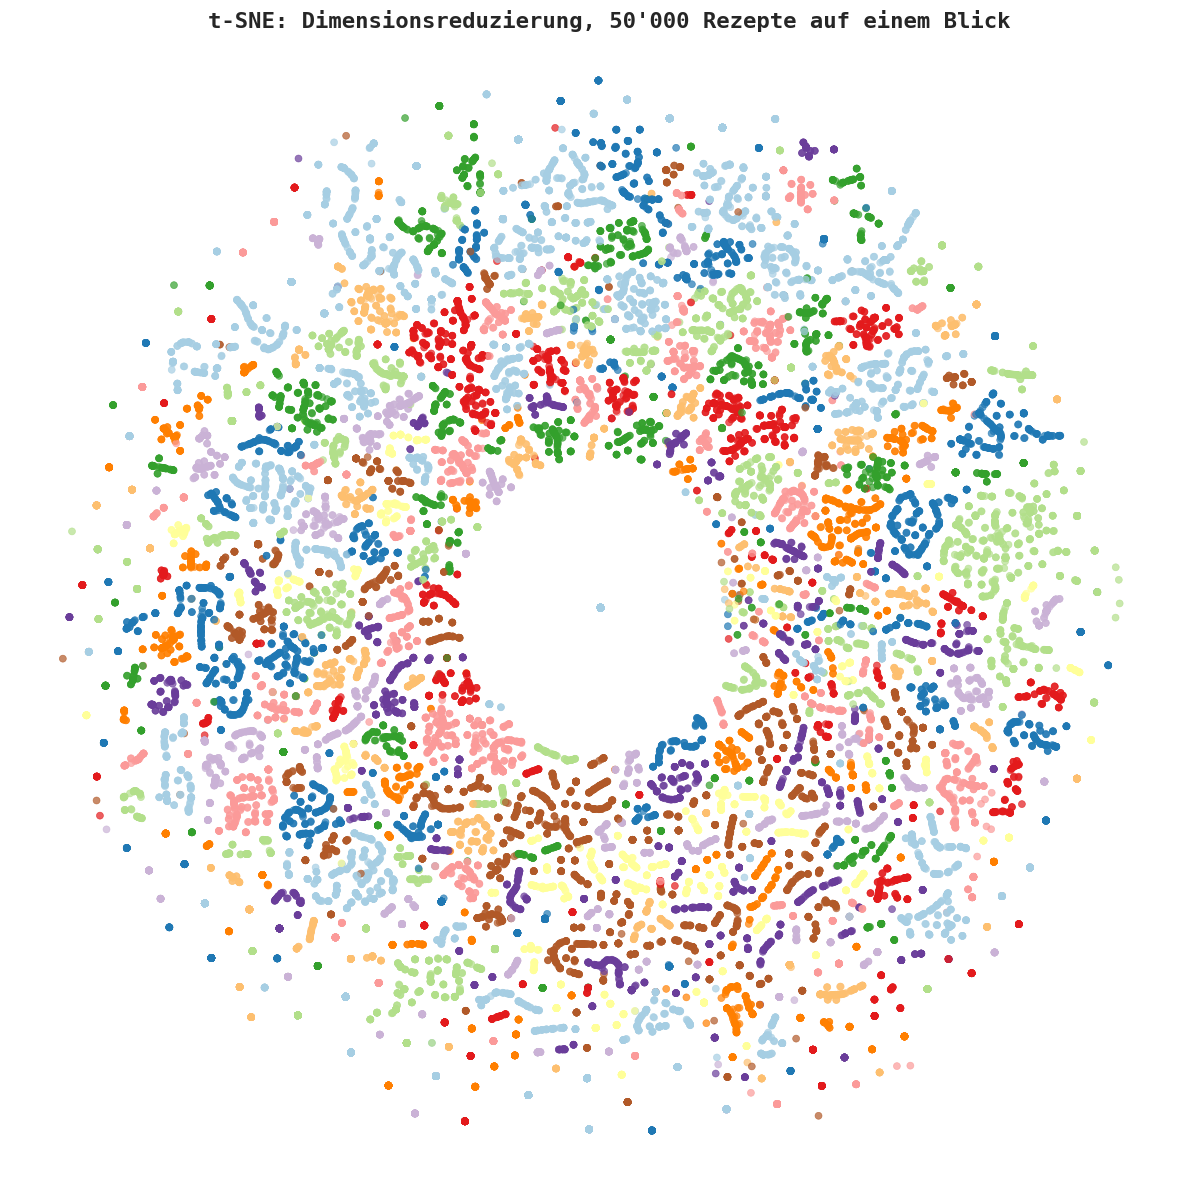

In [160]:
matplotlib.rc('font',family='monospace')
plt.style.use('seaborn-poster')

fig, axs = plt.subplots(1,1, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.001)

#data = tsne_embedding
scatter = plt.scatter(data=tsne_embedding,x='x',y='y',s=25, c=tsne_embedding['hue'], cmap="Paired", alpha=0.7)
plt.axis('off')
plt.annotate('t-SNE: Dimensionsreduzierung, 50\'000 Rezepte auf einem Blick', xy=(0.17, 1), xycoords='axes fraction',
            fontsize = 16, weight = 'bold', alpha = .85)

plt.show()

# Not run below -zhuoyu

In [161]:
legend_list = []
colors = []
for i in range(len(topics_category_300)):
    idx = np.where(tsne_embedding['hue']==i)[0][0]
    color = scatter.get_facecolors()[idx]
    colors.append(color)
    legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))

IndexError: index 0 is out of bounds for axis 0 with size 0

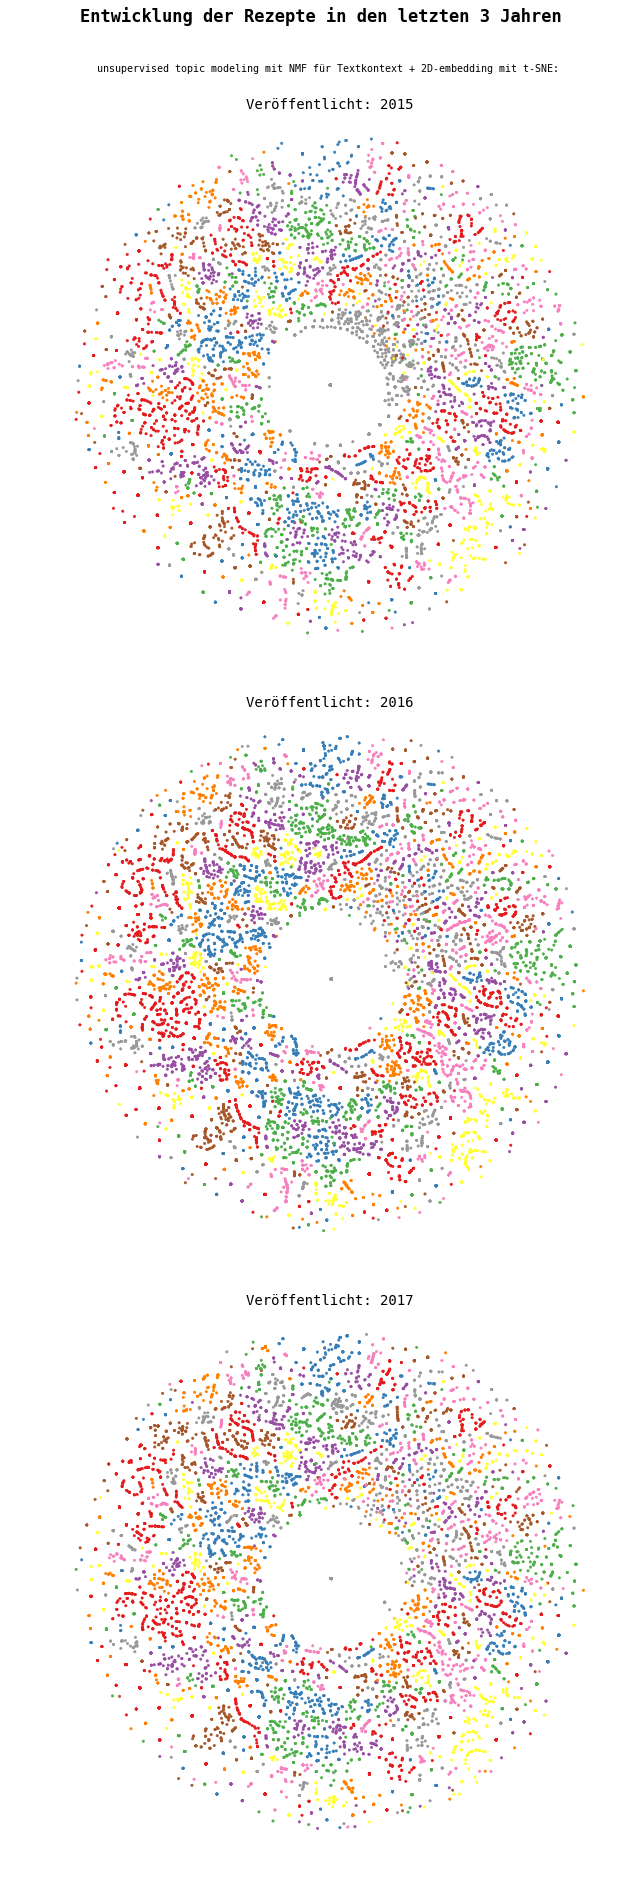

In [175]:
plt.style.use('ggplot')


fig, axs = plt.subplots(3,1, figsize=(10, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0.1)

axs = axs.ravel()

sorted_dataframe = rezepte_csv_analysis.sort_values(by='year', ascending=True)[266755:]
sorted_dataframe = sorted_dataframe.reset_index(drop=True)
count = 0
legend = []
for year, idx in zip([2015,2016,2017], range(3)):
    if year == 2015: data = tsne_embedding[sorted_dataframe['year']==year]
    elif year == 2016: data = tsne_embedding[sorted_dataframe['year']==year]
    elif year == 2017: data = tsne_embedding[sorted_dataframe['year']==year]
    scatter = axs[idx].scatter(data=data,x='x',y='y',s=6,c=data['hue'],cmap="Set1")
    axs[idx].set_title('Veröffentlicht: {}'.format(year),**{'fontsize':'14'})
    axs[idx].axis('off')

plt.suptitle("Entwicklung der Rezepte in den letzten 3 Jahren",**{'fontsize':'17','weight':'bold'})
plt.figtext(.51,0.95,'unsupervised topic modeling mit NMF für Textkontext + 2D-embedding mit t-SNE:', **{'fontsize':'10','weight':'light'}, ha='center')


#fig.legend(legend_list[:20],topics_category_300[:20],loc=(0.1,0.89))
plt.subplots_adjust(top=0.93)
plt.savefig('tsne_50000_3_years.pdf', format='pdf')
plt.show()

# Bilder Umbennenung
### Da man nun für jedes Rezept die passende Kategorie hat, kann man nun einen Ordner pro Kategorie machen mit den richtigen Bildern im richtigen Verzeichnis

In [309]:
import os

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [3]:
def movePic(src, dest):
    os.rename(src, dest)

In [14]:
directories_names = []

for directt in topics_category_300:
    d_name = directt.replace(' ', '_')
    directories_names.append(d_name)

for curr_dir_category in directories_names:
    createFolder('./input/images/images/' + curr_dir_category)

In [4]:
!ls input/images/search_images/ | head -10

recipe-100001040044233-1.jpg
recipe-100001040044233-10.jpg
recipe-100001040044233-11.jpg
recipe-100001040044233-12.jpg
recipe-100001040044233-13.jpg
recipe-100001040044233-14.jpg
recipe-100001040044233-15.jpg
recipe-100001040044233-16.jpg
recipe-100001040044233-17.jpg
recipe-100001040044233-18.jpg


In [7]:
import csv
def get_recipe_id_cat():
    recipe_names_id_ = []
    recipe_names_cat_ = []
    skip_first = True # col name
    chef_file = 'input/test/chefkoch_rezepte_analysis_with_category.csv'
    with open(chef_file, 'r') as f:
        chefkoch = csv.reader(f)
        for row in chefkoch:
            if skip_first:
                skip_first = False
                continue
            try:
                recipe_names_id_.append(row[1])
                recipe_names_cat_.append(row[6])
            except:
                print('ERROR')
                continue 
    return recipe_names_id_, recipe_names_cat_

In [8]:
get_recipe_id_cat_ID, get_recipe_id_cat_CAT = get_recipe_id_cat()

from itertools import zip_longest
def create_dict(keys, values):
    return dict(zip_longest(keys, values[:len(keys)]))

id_key_cat_value = create_dict(get_recipe_id_cat_ID, get_recipe_id_cat_CAT)

In [ ]:
id_key_cat_value

In [ ]:
#input/images/search_thumbnails/recipe-100001040044233-0.jpg
#input/images/search_thumbnails/recipe-1000011205319453-0.jpg
#input/images/search_thumbnails/recipe-1000021205319843-0.jpg
# ...
import os
THUMBNAIL_DIR = 'input/images/search_thumbnails/'
OLD_IMG_DIR = 'input/images/search_images/'
files_moved = 0
for filename in os.listdir(THUMBNAIL_DIR):
    #print(os.path.join(THUMBNAIL_DIR, filename))
    if filename.endswith(".jpg"):
        comp_id = filename.split('-')[1]
        cat_val = id_key_cat_value.get(comp_id, '_')
        if cat_val == '_': continue
        cat_val = cat_val.replace(' ', '_')
        new_image_dest = cat_val+'-'+str(comp_id)+'-'+ str(filename.split('-')[2])+'.jpg'
        movePic(THUMBNAIL_DIR+filename, 'input/images/images/'+cat_val+'/'+new_image_dest)
        files_moved+=1
        if files_moved%10000==0: print('+= 10000')

## Zu wie vielen Bildern konnte keine Kategorie berechnet werden?

In [20]:
print(len([name for name in os.listdir('input/images/images/no_cat/') if name.endswith(".jpg")]))

305115


## Wie viele Bilder hat man nun pro Kategorie?

In [19]:
ALL_IMGS_DIR = 'input/images/images/'

for directory_ in directories_names:
    print('{} -> '.format(directory_), end='')
    print(len([name for name in os.listdir(os.path.join(ALL_IMGS_DIR, directory_)) if name.endswith(".jpg")]), end='\n')

spaghetti -> 6259
salat -> 4822
nudeln -> 3744
muffins -> 8074
nudelsalat -> 2399
tomaten -> 1579
torte -> 10338
kuchen -> 6445
pasta -> 2674
hähnchen -> 2725
kartoffel -> 1755
error -> 2331
apfelkuchen -> 8848
schweinefilet -> 2539
paprika -> 2606
kartoffelsalat -> 2992
apfel -> 3394
lachs -> 2337
gemüse -> 1816
käsekuchen -> 4707
spargel -> 2778
zucchini -> 2962
curry -> 1455
nudelauflauf -> 2189
rote_bete -> 2152
schoko -> 3373
bananen -> 2412
suppe -> 1430
hähnchenbrust -> 1473
käse -> 1381
reis -> 1960
gnocchi -> 2549
erdbeer -> 2704
lasagne -> 2981
pfannkuchen -> 2698
pizza -> 3165
quark -> 2640
auflauf -> 1354
kürbis -> 1735
ricotta -> 783
bandnudeln -> 1113
tiramisu -> 2756
kartoffeln -> 1862
dip -> 817
kartoffelsuppe -> 1491
feldsalat -> 1313
eier -> 2012
sauce -> 1561
tortellini -> 1411
joghurt -> 1858
champignons -> 1042
schnitzel -> 2484
penne -> 1125
kürbissuppe -> 941
bohnen -> 1183
smoothie -> 1554
creme -> 1591
brot -> 5326
spinat -> 1721
chili -> 1438
kirsch -> 3808
ta

# Nun hat man alle nötigen Datensätze für das Convolutional Neural Network (5. Teil)